<a href="https://www.kaggle.com/code/yeoyunsianggeremie/s3e16-ensemble-private-score-1-33948?scriptVersionId=135483259" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a class="anchor" id="import"></a>
# <p style="padding:10px;background-color:#247378;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> **S3E16 Notebook: Regression with Crab Age Dataset** </p> 

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Changing Cell Styles</p>

In [1]:
#https://www.kaggle.com/competitions/playground-series-s3e14/discussion/410627

!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DATA_DIR = '/kaggle/input/playground-series-s3e16/'

/kaggle/input/s3e16-additional-synthetic-data/synthetic_data_1.csv
/kaggle/input/s3e16-additional-synthetic-data/synthetic_data_2.csv
/kaggle/input/s3e16-additional-synthetic-data/synthetic_data_3.csv
/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv
/kaggle/input/crab-age-prediction/CrabAgePrediction.csv
/kaggle/input/ps-s3-e16-synthetic-train-data/train_synthetic.csv


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Libraries</p>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from colorama import Style, Fore, Back
## Set Plot Parameters       
plt.style.use("Solarize_Light2")
color_pal = ["#4CAF50", "#780060", "#FFBF00", "#6495ED", "#DE3163",
             "#922710", "#C99BE8", "#FF8700", "#E0FF00", "#2E00FF"]

from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
from catboost import CatBoostRegressor
from sklearn import set_config
import gc

import warnings
warnings.filterwarnings('ignore')

set_config(transform_output = 'pandas')

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)

In [4]:
TRAIN_SIZE = 74051

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Examine Data</p>

In [5]:
class DataLoader:
    def __init__(self, DATA_DIR, read_original=True, original_dir=""):
        
        self.train = pd.read_csv(DATA_DIR + "train.csv")
        self.test = pd.read_csv(DATA_DIR + "test.csv")
        self.read_original = read_original
        if self.read_original:
            self.original = pd.read_csv(original_dir)
        
    def drop_index(self, cols):
        try:
            self.train = self.train.drop(columns = cols)
        except:
            pass
        
        try:
            self.test = self.test.drop(columns = cols)
        except:
            pass
        
        try:
            if self.read_original:
                self.original = self.original.drop(columns = cols)
        except:
            pass
        
        #removing this reduces 10 fold CV MAE -> try on unseen data first
        if self.read_original:
            self.train = pd.concat([self.train, self.original]).reset_index().drop(columns = ["index"])
        
        return (self.train, self.test)
        

In [6]:
orig_dir = "/kaggle/input/crab-age-prediction/CrabAgePrediction.csv"
more_dir = "/kaggle/input/ps-s3-e16-synthetic-train-data/train_synthetic.csv"
#dl = DataLoader(DATA_DIR, False, orig_dir)
more = pd.read_csv(more_dir).drop(columns = ["id"])
dl = DataLoader(DATA_DIR, True, orig_dir)
train, test = dl.drop_index(["id"])
train = pd.concat([train, more]).reset_index().drop(columns = ["index"])

In [7]:
train

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...
201334,F,1.5625,1.2250,0.4625,32.984643,13.990478,7.257472,9.497082,10
201335,M,1.6500,1.2875,0.4125,43.828327,19.646203,8.278054,10.064072,10
201336,M,1.5500,1.2500,0.4125,32.956294,15.563875,6.888928,9.497082,9
201337,I,1.3000,1.0000,0.3000,16.839603,8.845044,3.727959,4.791066,8


In [8]:
test

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066
...,...,...,...,...,...,...,...,...
49363,F,1.3000,1.0375,0.3250,16.315137,6.690482,5.173784,3.756309
49364,I,1.0375,0.7625,0.2625,10.276694,4.436697,1.998640,3.543687
49365,F,1.4875,1.1625,0.3625,31.382897,11.396499,6.846404,8.788345
49366,F,1.2375,0.9500,0.2875,15.663099,6.095142,3.727959,4.961163


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Summary Statistics</p>

In [9]:
class EDA:
    def __init__(self, train, test, cat_cols, num_cols):
        self.train = train
        self.test = test
        self.cat_cols = cat_cols
        self.num_cols = num_cols
    
    def summary(self):
        
        #beautify dataframe: reference https://www.kaggle.com/code/tetsutani/ps3e15-eda-ensemble-and-stacking-baseline
        def set_frame_style(self, caption=""):
            """Helper function to set dataframe presentation style.
            """
            return self.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'Blue'),
                ('font-size', '18px'),
                ('font-weight','bold')
            ]}])
        
        print(f'{Style.BRIGHT}{Fore.BLACK}Head of the dataset \n \n {"*"*100}')
        display(self.train.head(3))
        print(f'\n {Style.BRIGHT}{Fore.BLACK}{"*"*100}\n')
        print(f"{Style.BRIGHT}{Fore.BLACK}Summary of the dataset ---->  dataset has {Fore.RED}{self.train.shape[1]-1}{Fore.BLACK} features and {Fore.RED}{self.train.shape[0]}{Fore.BLACK} examples.")
        print(f'\n{Style.BRIGHT}{Fore.BLACK}{"*"*100}\n{Style.RESET_ALL}')
        summary = pd.DataFrame(index=self.train.columns)
        desc = pd.DataFrame(self.train.describe(include='all').transpose())
        summary["Count"] = desc['count'].values
        summary["Unique"] = self.train.nunique().values
        summary["Missing"] = self.train.isnull().sum().values
        summary["Duplicated"] = self.train.duplicated().sum()
        summary['Std'] = desc['std'].values
        summary["Mode"] = self.train.mode().values[0]
        summary["Median"] = self.train.median()
        summary['Mean'] = desc['mean'].values
        summary['Min'] = desc['min'].values
        summary['Max'] = desc['max'].values
        summary["First Value"] = self.train.loc[0].values
        summary["Last Value"] = self.train.loc[self.train.shape[0]-1].values
        summary["Types"] = self.train.dtypes
        return display(set_frame_style(summary, "Summary Statistics"))
    
    def distribution(self):
        
        # check numerical variables' distribution
        # https://www.kaggle.com/code/kimtaehun/complete-eda-and-xgb-baseline-guide

        features = self.num_cols
        n_bins = 50
        histplot_hyperparams = {
            'kde':True,
            'alpha':0.4,
            'stat':'percent',
            'bins':n_bins
        }

        columns = features
        n_cols = 4
        n_rows = math.ceil(len(columns)/n_cols)
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
        ax = ax.flatten()

        for i, column in enumerate(columns):
            plot_axes = [ax[i]]
            sns.kdeplot(
                self.train[column], label='Train',
                ax=ax[i], color='#9E3F00'
            )

            #sns.kdeplot(
                #original[column], label='Original',
                #ax=ax[i], color='#471033'
            #)

            if column != "Age":
                sns.kdeplot(
                    self.test[column], label='Test',
                    ax=ax[i], color='yellow'
                )

            # titles
            ax[i].set_title(f'{column} Distribution');
            ax[i].set_xlabel(None)

            # remove axes to show only one at the end
            plot_axes = [ax[i]]
            handles = []
            labels = []
            for plot_ax in plot_axes:
                handles += plot_ax.get_legend_handles_labels()[0]
                labels += plot_ax.get_legend_handles_labels()[1]
                plot_ax.legend().remove()

        for i in range(i+1, len(ax)):
            ax[i].axis('off')

        fig.suptitle(f'Numerical Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
        plt.tight_layout()
        
    def correlation(self):
        corr = self.train.corr()
        fig, axes = plt.subplots(figsize=(14, 8))
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
        plt.title("Train Dataset Correlation")
        plt.show()
        
    

In [10]:
eda = EDA(train, test, train.columns[:1], train.columns[1:])

In [11]:
eda.summary()

Head of the dataset 
 
 ****************************************************************************************************


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,I,1.5250,1.1750,0.375,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.275,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.375,24.777463,11.339800,5.556502,6.662133,9



 ****************************************************************************************************

Summary of the dataset ---->  dataset has 8 features and 201339 examples.

****************************************************************************************************



,Count,Unique,Missing,Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
Sex,201339,3,0,211,nan,M,nan,nan,nan,nan,I,F,object
Length,201339.000000,158,0,211,0.289059,1.562500,1.375000,1.314658,0.187500,2.764076,1.525000,1.625000,float64
Diameter,201339.000000,129,0,211,0.238388,1.125000,1.075000,1.022254,0.087500,1.625000,1.175000,1.312500,float64
Height,201339.000000,75,0,211,0.091948,0.375000,0.362500,0.346935,0.000000,2.825000,0.375000,0.475000,float64
Weight,201339.000000,3779,0,211,12.662340,32.162508,23.671833,23.248462,0.042524,80.101512,28.973189,42.821920,float64
Shucked Weight,201339.000000,2021,0,211,5.626004,2.721552,9.879801,10.042114,0.014175,42.184056,12.728926,16.173390,float64
Viscera Weight,201339.000000,1064,0,211,2.800039,5.868347,4.904464,5.024450,0.014175,21.545620,6.647958,8.632423,float64
Shell Weight,201339.000000,1141,0,211,3.583867,8.930093,6.803880,6.678436,0.042524,32.786197,8.348928,11.056305,float64
Age,201339.000000,28,0,211,3.203939,9,10.000000,9.954892,1.000000,29.000000,9,13,int64


<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Roboto; text-align:left">

<h3 align="left"><font color='#800080'>Insights:</font></h3>

- There are no missing values in both the original and train dataset -> no need for imputation
- Sex is categorical, others are numeric variables

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Distribution of dataset</p>

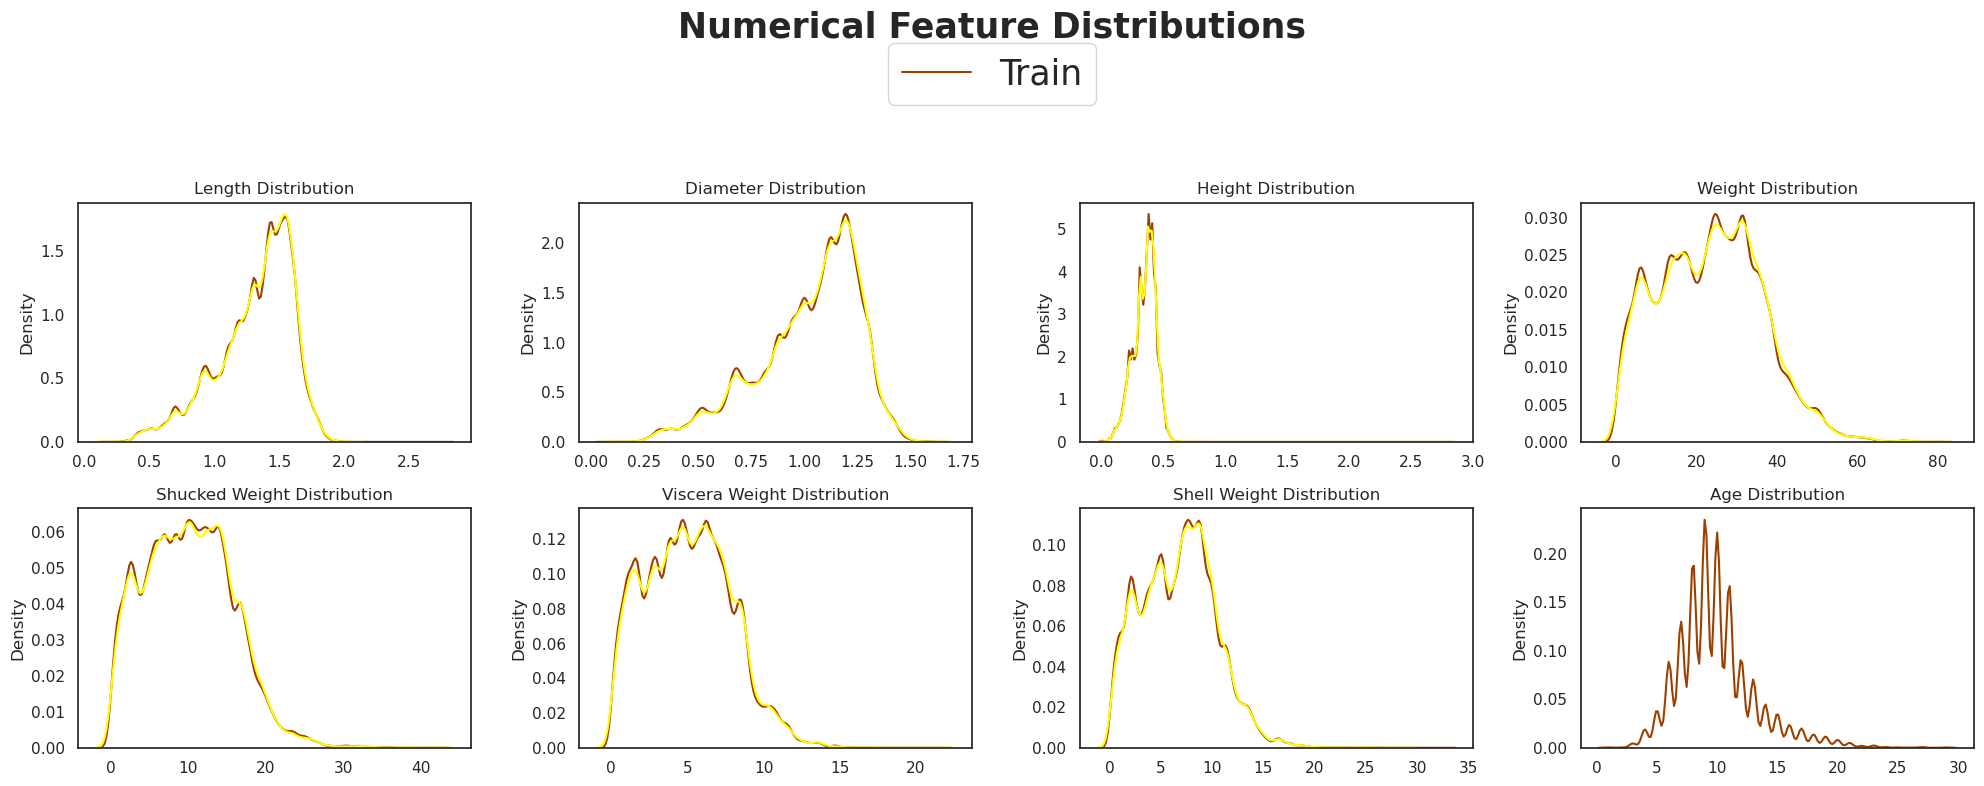

In [12]:
eda.distribution()

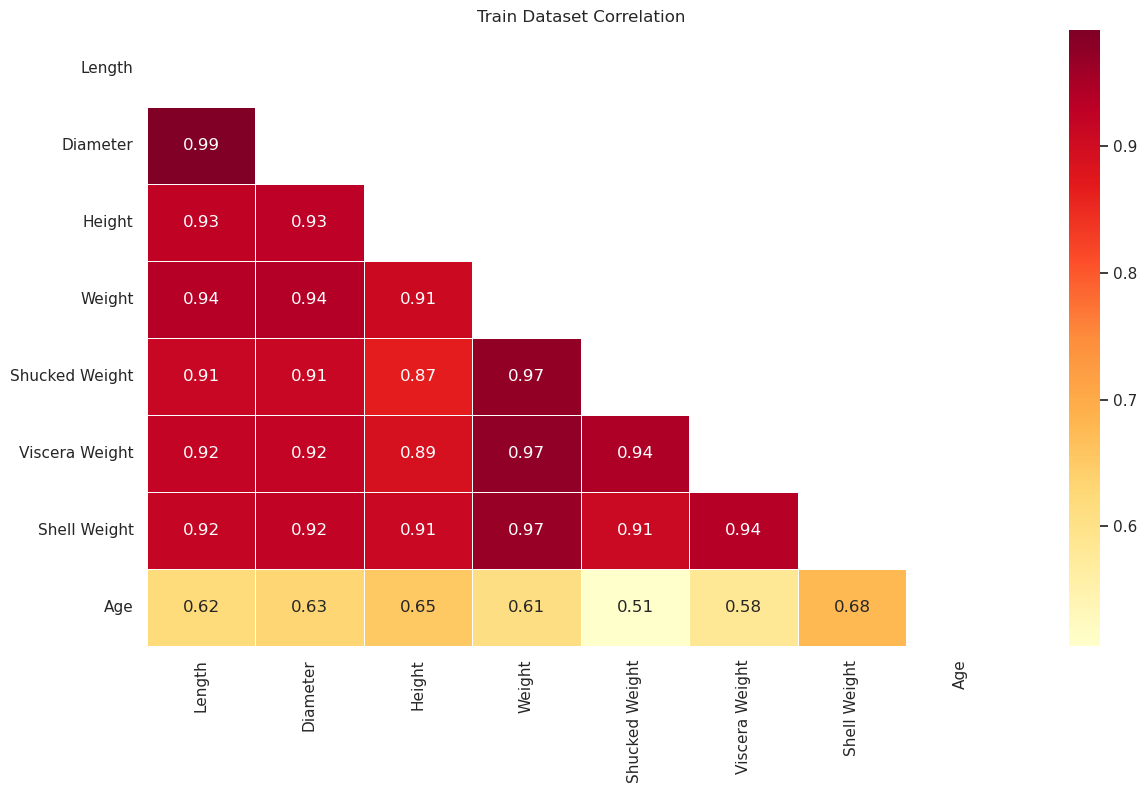

In [13]:
eda.correlation()

<div style="border-radius:10px; border:#800080 solid; padding: 15px; background-color: #c8a2c8; font-size:100%; font-family:Roboto; text-align:left">

<h3 align="left"><font color='#800080'>Insights:</font></h3>

- Height, Weight, Shucked Weight, Viscera Weight, Shell Weight all seem to be right skewed -> we can apply log transform to all of these
    
- Lots of strong correlations between predictor variables here! All of them seem to be similarly correlated to age (0.5 to 0.65) -> we might choose to remove some variables

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Data Transformation</p>

In [14]:
train["Height"] = np.log(train["Height"])
train["Weight"] = np.log(train["Weight"])
train["Shucked Weight"] = np.log(train["Shucked Weight"])
train["Viscera Weight"] = np.log(train["Viscera Weight"])
train["Shell Weight"] = np.log(train["Shell Weight"])

test["Height"] = np.log(test["Height"])
test["Weight"] = np.log(test["Weight"])
test["Shucked Weight"] = np.log(test["Shucked Weight"])
test["Viscera Weight"] = np.log(test["Viscera Weight"])
test["Shell Weight"] = np.log(test["Shell Weight"])

In [15]:
train = pd.get_dummies(train, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

In [16]:
train

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_I,Sex_M
0,1.5250,1.1750,-0.980829,3.366371,2.543877,1.894310,2.122133,9,1,0
1,1.1000,0.8250,-1.290984,2.343577,1.508898,0.843573,1.224346,8,1,0
2,1.3875,1.1125,-0.980829,3.209934,2.428319,1.714969,1.896440,9,0,1
3,1.7000,1.4125,-0.693147,3.925148,3.013324,2.397153,2.707843,11,0,0
4,1.2500,1.0125,-1.086190,3.147986,2.483044,1.505758,1.783962,8,1,0
...,...,...,...,...,...,...,...,...,...,...
201334,1.5625,1.2250,-0.771109,3.496042,2.638377,1.982032,2.250985,10,0,0
201335,1.6500,1.2875,-0.885519,3.780280,2.977884,2.113608,2.308972,10,0,1
201336,1.5500,1.2500,-0.885519,3.495182,2.744953,1.929916,2.250985,9,0,1
201337,1.3000,1.0000,-1.203973,2.823733,2.179857,1.315861,1.566753,8,1,0


In [17]:
test

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_I,Sex_M
0,1.0500,0.7625,-1.290984,2.153882,1.296667,0.547728,1.001202,1,0
1,1.1625,0.8875,-1.290984,2.741303,1.950283,1.177429,1.378497,1,0
2,1.2875,0.9875,-1.123930,2.679077,1.714969,1.356835,1.572653,0,0
3,1.5500,0.9875,-0.948039,3.345609,2.593833,1.879272,1.950283,0,0
4,1.1125,0.8500,-1.337504,2.465133,1.709854,0.902762,1.203292,1,0
...,...,...,...,...,...,...,...,...,...
49363,1.3000,1.0375,-1.123930,2.792093,1.900686,1.643604,1.323437,0,0
49364,1.0375,0.7625,-1.337504,2.329879,1.489910,0.692467,1.265168,1,0
49365,1.4875,1.1625,-1.014731,3.446263,2.433306,1.923724,2.173426,0,0
49366,1.2375,0.9500,-1.246532,2.751308,1.807492,1.315861,1.601640,0,0


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Build Model!</p>

In [18]:
X_train = train.drop(columns = ["Age"])
X_test = test
y_train = train['Age'].copy()

params = {'metric': 'mae',"random_state":123,
          'objective':'regression_l1', 'colsample_bytree': .4, 
          'verbosity': -1,'n_jobs': -1,"n_estimators":500,
          'learning_rate': 0.06,'subsample': .5, 'num_iterations':2000
         }

NFOLDS = 10
FACTOR = 0.5

#for FACTOR in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
#for FACTOR in [0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75]:
print(f"Weight {Fore.CYAN}{FACTOR} {Fore.BLACK} to CatBoost --->")
folds = KFold(n_splits=10, shuffle = True, random_state = 123)

splits = folds.split(X_train, y_train)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
for fold_n, (train_index, valid_index) in enumerate(splits):

    #--------------------------------CATBOOST--------------------------------------------

    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]
    catboost_reg = CatBoostRegressor(loss_function = "MAE", random_state=123, \
                                     cat_features=[], early_stopping_rounds=200, iterations=1000, \
                                     grow_policy="Lossguide", max_leaves=41, verbose=False)
    catboost_reg.fit(X_tr, y_tr, eval_set=(X_val, y_val), silent=True)
    y_pred_valid_cat = catboost_reg.predict(X_val)
    y_pred_train_cat = catboost_reg.predict(X_tr)

    #--------------------------------LIGHTGBM--------------------------------------------

    lightgbm_reg = LGBMRegressor(**params, verbose=-1)
    lightgbm_reg.fit(X_tr, y_tr, eval_set=(X_val, y_val), 
                     callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=0)])
    y_pred_valid_lgbm = lightgbm_reg.predict(X_val)
    y_pred_train_lgbm = lightgbm_reg.predict(X_tr)

    #--------------------------------COMBINED--------------------------------------------
    y_pred_valid = np.round(
                        (FACTOR * y_pred_valid_cat) + ((1 - FACTOR) * y_pred_valid_lgbm)
                    )
    y_pred_train = np.round(
                        (FACTOR * y_pred_train_cat) + ((1 - FACTOR) * y_pred_train_lgbm)
                    )
    y_oof[valid_index] = y_pred_valid

    print(f"Fold {fold_n + 1} | Train MAE | {mean_absolute_error(y_tr, y_pred_train)}")

    print(f"Fold {fold_n + 1} | MAE: {mean_absolute_error(y_val, y_pred_valid)}")
    score += mean_absolute_error(y_val, y_pred_valid) / NFOLDS

    # Predict the test set
    cur_preds = (FACTOR * catboost_reg.predict(X_test)) + ((1 - FACTOR) * lightgbm_reg.predict(X_test))
    y_preds += cur_preds / NFOLDS
    del X_tr, X_val, y_tr, y_val
    gc.collect()

print(f"\nMean MAE = {Fore.LIGHTMAGENTA_EX}{score}{Fore.BLACK}")
print(f"Out of folds MAE = {Fore.GREEN}{mean_absolute_error(y_train, y_oof)}{Fore.BLACK}")
print(f"Out of folds ROC Generated = {Fore.BLUE}{mean_absolute_error(y_train[:TRAIN_SIZE], y_oof[:TRAIN_SIZE])}{Fore.BLACK}")

Weight 0.5  to CatBoost --->
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1235]	valid_0's l1: 1.32211
Fold 1 | Train MAE | 1.2679617008360697
Fold 1 | MAE: 1.3013807489818219
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1014]	valid_0's l1: 1.32393
Fold 2 | Train MAE | 1.2701139593278332
Fold 2 | MAE: 1.3029204330982418
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1026]	valid_0's l1: 1.33086
Fold 3 | Train MAE | 1.2711514582930934
Fold 3 | MAE: 1.3103208503029702
[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current va

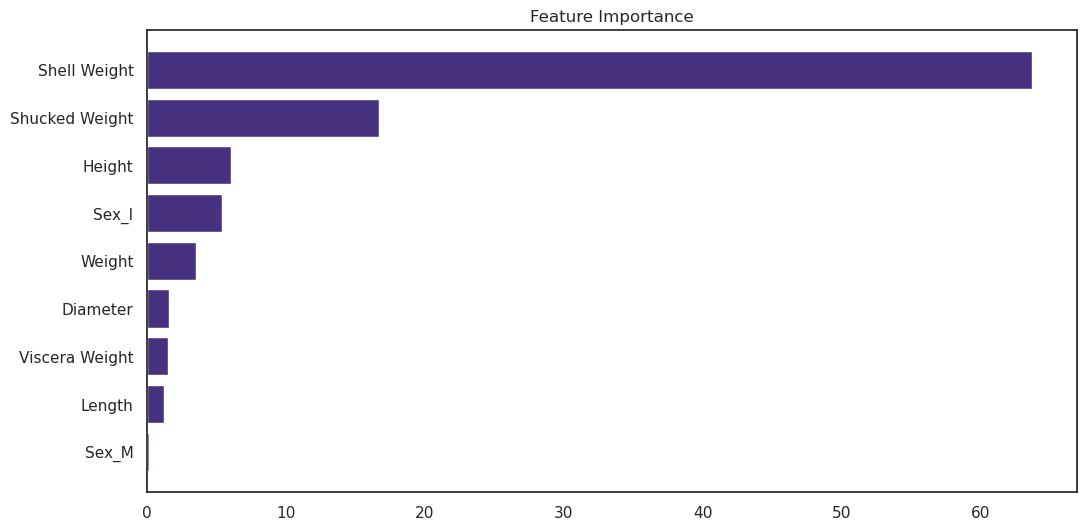

In [19]:
feature_importance = catboost_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [20]:
CV_train = 0.25 * score

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Testing on unseen synthetic data</p>

In [21]:
first = pd.read_csv(
    "/kaggle/input/s3e16-additional-synthetic-data/synthetic_data_1.csv"
).drop(columns = ["id"])
second = pd.read_csv(
    "/kaggle/input/s3e16-additional-synthetic-data/synthetic_data_2.csv"
).drop(columns = ["id"])
third = pd.read_csv(
    "/kaggle/input/s3e16-additional-synthetic-data/synthetic_data_3.csv"
).drop(columns = ["id"])

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Score = 0.25 * (CV_train + CV_1 + CV_2 + CV_3) </p>

In [22]:
for i, df in enumerate([first, second, third]):
    
    df2 = df.copy()
    
    df2["Height"] = np.log(df2["Height"])
    df2["Weight"] = np.log(df2["Weight"])
    df2["Shucked Weight"] = np.log(df2["Shucked Weight"])
    df2["Viscera Weight"] = np.log(df2["Viscera Weight"])
    df2["Shell Weight"] = np.log(df2["Shell Weight"])
    
    df2 = pd.get_dummies(df2, drop_first = True)
    
    new_X = df2.drop(columns = ["Age"])
    new_Y = df2["Age"].copy()
    
    cat_pred = catboost_reg.predict(new_X)
    lgbm_pred = lightgbm_reg.predict(new_X)
    
    s1 = mean_absolute_error(new_Y, cat_pred)
    s2 = mean_absolute_error(new_Y, lgbm_pred)
    
    mae = 0.5 * (s1 + s2)
    print(f"Dataset {i+1}: Mean MAE = {Fore.BLUE}{mae}{Fore.BLACK}")
    
    CV_train += (0.25 * mae)
    

print(f"Overall CV MAE = {Fore.GREEN}{CV_train}{Fore.BLACK}")
    

Dataset 1: Mean MAE = 1.2931905861400992
Dataset 2: Mean MAE = 1.2952634256192335
Dataset 3: Mean MAE = 1.2720347908135348
Overall CV MAE = 1.2898196015114305


In [23]:
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')
sub['Age'] = np.round(y_preds)
sub.to_csv('submission.csv',index=False)
sub

,id,Age
0,74051,7.0
1,74052,8.0
2,74053,10.0
3,74054,9.0
4,74055,7.0
...,...,...
49363,123414,9.0
49364,123415,8.0
49365,123416,13.0
49366,123417,9.0
